# Backward PDE Program for Black Scholes

1. Crank-Nicolson method for Linear diffusion

$\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2}$

$\frac{u^{n+1}_i-u^n_i}{\Delta t} = \frac{a}{2(\Delta x)^2} \left((u^{n+1}_{i+1}-2u^{n+1}_i+u^{n+1}_{i-1})+(u^n_{i+1}-2u^n_i+u^n_{i-1})\right)$

or, let $r=\frac{a\Delta t}{2(\Delta x)^2}$:

$-ru^{n+1}_{i-1}+(1+2r)u^{n+1}_i-ru^{n+1}_{i+1} = ru^n_{i-1}+(1-2r)u^n_i+ru^n_{i+1}$

Boundary condition:

$(1+2r)u^{n+1}_0 - ru^{n+1}_{1} = (1-2r)u^n_0 + ru^n_{1}$

$-ru^{n+1}_{NX-1} + (1+2r)u^{n+1}_{NX} = ru^n_{NX-1} + (1-2r)u^n_{NX}$

# Initialization

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import diags
from scipy.linalg import lu
from mpl_toolkits import mplot3d
plt.style.use('ggplot')

# Initial and Boundary Condition

- Initial Condition: $u(S_i,T) = (S_i-K)^+$.

- Boundary Condition: $u(S_0, t_j) = 0, \quad u(S_{Max}, t_j) = S_{Max} - K e^{-r t_j}$.

In [33]:
def initial_cond(NS, S_grid, K):
    return np.maximum(np.zeros(NS+1), S_grid-K)     # Call Option Payoff

def boundary_cond(cond, S, K, r, NT, t_grid):
    if cond == 'low':
        boundary_values = np.zeros(NT+1)            # lower boundary
    elif cond == 'up':
        boundary_values = S-K * np.exp(-r * t_grid) # upper boundary
    return boundary_values

# Backward Diffusion of Black Scholes PDE

In [34]:
def pde_matrix_coef(dt, r, sigma, NS):
    i = np.arange(NS+1)
    aa = dt * (sigma * sigma * i * i - r * i) / 4
    bb = - dt * (sigma * sigma * i * i + r) / 2
    cc = dt * (sigma * sigma * i * i + r * i) / 4
    return aa, bb, cc

def tridiag_matrix(NS, aa, bb, cc):
    return diags([aa[1:], bb[1:], cc[1:]], [0,1,2], shape=(NS-1,NS+1)).toarray()        # generate NS-1 row, NS+1 coef matrix
     

def black_scholes_pde(K, T, r, sigma, NS, NT, Smin, Smax, S_grid, t_grid):
    dS = (Smax - Smin) / NS
    dt = T / NT
    u_next = initial_cond(NS, S_grid, K)                           # initial condition
    u_low_bound = boundary_cond('low', Smin, K, r, NT, t_grid)     # lower boundary
    u_up_bound = boundary_cond('up', Smax, K, r, NT, t_grid)       # upper boundary
    u_all = np.zeros((NS+1, NT+1))                                 # to store the premium at all nodes
    u_all[:,0] = u_next

    # backword diffusion: mtx_lhs * u = mtx_rhs * u_next
    for j in range(NT):
        aa, bb, cc = pde_matrix_coef(dt, r, sigma, NS)      # 1. build component coefficients in tridiagonal matrix
        
        mtx_lhs = tridiag_matrix(NS, -aa, 1-bb, -cc)        # 2. build tridiagonal matrix
        mtx_lhs_trunc = mtx_lhs[:,1:-1]
        mtx_rhs = tridiag_matrix(NS, aa, 1+bb, cc)
        
        result_rhs = np.dot(mtx_rhs, u_next)                # 3. build result of RHS
        result_rhs[0] += aa[1] * u_low_bound[j+1]           # 4. handle boundary condition of RHS
        result_rhs[-1] += cc[NS-1] * u_up_bound[j+1]

   #     P, L, U = lu(mtx_lhs_trunc)                        # (LHS - generate LU decomposition)
   #     temp =  np.dot(np.linalg.inv(L), result_rhs)       # (LHS - use LU decomposition)
   #     u = np.dot(np.linalg.inv(U), temp)

        u = np.linalg.solve(mtx_lhs_trunc, result_rhs)      # 5. solve u (Here we use Numpy's solving function directly)

        u_next[1:-1] = u
        u_next[0] = u_low_bound[j+1]                        # 6. handle boundary condition of RHS
        u_next[-1] = u_up_bound[j+1]

        u_all[:,j+1] = u_next
    return u_all

# Black Scholes Closed-Form Formula

In [35]:
def black_scholes_vanilla(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma * sigma) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    callPrem = Nd1 * S - Nd2 * K * np.exp(- r * T)
    return callPrem

# Main() Function

<IPython.core.display.Javascript object>


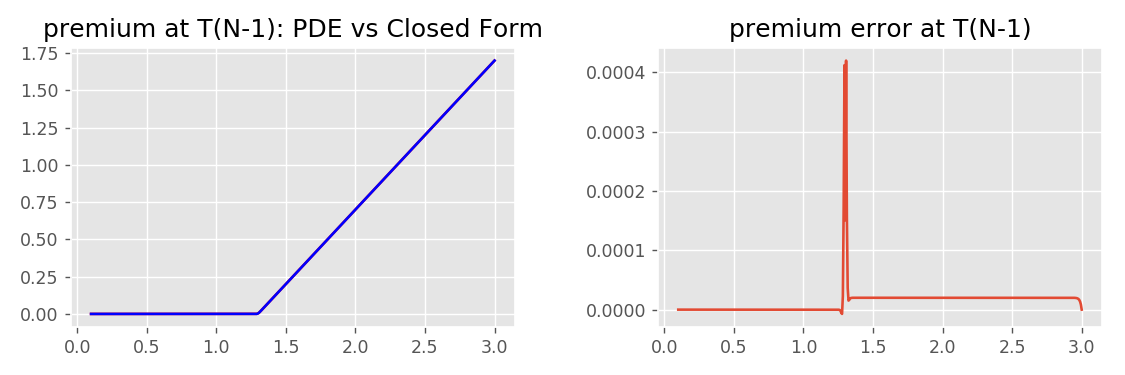

<IPython.core.display.Javascript object>


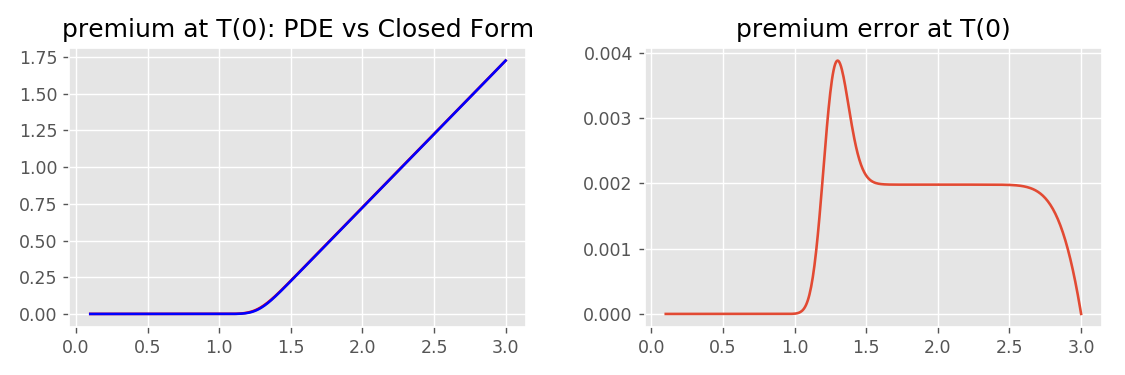

<IPython.core.display.Javascript object>


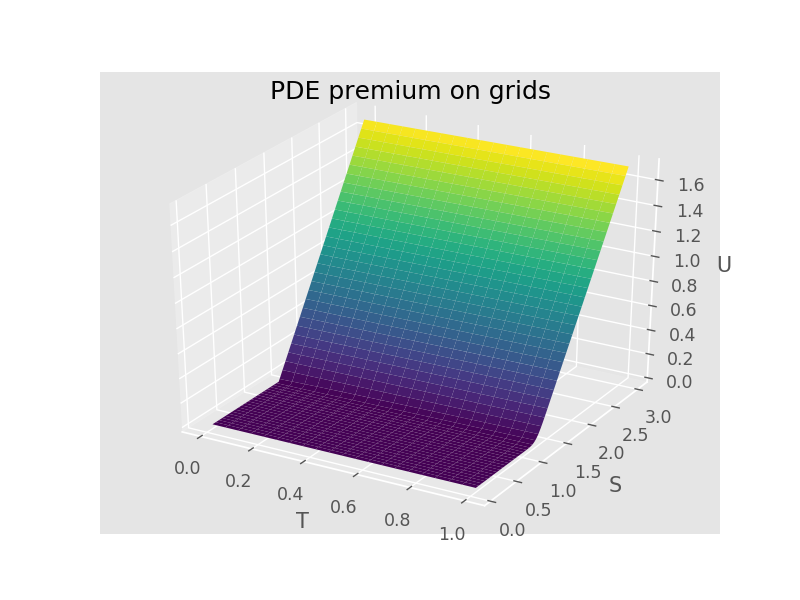

In [55]:
if __name__ == '__main__':
    # market data
    K = 1.3
    T = 1.0
    r = 0.02
    sigma = 0.07

    # scheme data
    NS = 500  # 0~300 steps, central point 150
    NT = 100  # 0~100 steps, central point 50                                                   
    Smin = 0.1 # boundary of x
    Smax = 3.0 # boundary of x

    S_grid = np.linspace(Smin, Smax, num=NS+1, endpoint=True)

    t_grid = np.linspace(0, T, num=NT+1, endpoint=True)

    prems_pde = black_scholes_pde(K, T, r, sigma, NS, NT, Smin, Smax, S_grid, t_grid)

    # closed-form premium at T[NT-1]
    prems_closed_t1 = black_scholes_vanilla(S_grid, K, t_grid[1], r, sigma)
    prems_error_t1 = prems_closed_t1 - prems_pde[:,1]
    # closed-form premium at T[0]
    prems_closed_tN = black_scholes_vanilla(S_grid, K, T, r, sigma)
    prems_error_tN = prems_closed_tN - prems_pde[:,-1]
    
    
    fig1 = plt.figure(figsize=(9, 3))
    fig1.subplots_adjust(hspace=3)
    plt.subplot(1,2,1)
    plt.title('premium at T(N-1): PDE vs Closed Form')
    plt.plot(S_grid, prems_closed_t1, color = 'r')
    plt.plot(S_grid, prems_pde[:,1], color = 'b')
    plt.subplot(1,2,2)
    plt.plot(S_grid, prems_error_t1)
    plt.title('premium error at T(N-1)')
    plt.tight_layout()
    plt.show()

    fig2 = plt.figure(figsize=(9, 3))
    plt.subplot(1,2,1)
    plt.title('premium at T(0): PDE vs Closed Form')
    plt.plot(S_grid, prems_closed_tN, color = 'r')
    plt.plot(S_grid, prems_pde[:,-1], color = 'b')
    plt.subplot(1,2,2)
    plt.plot(S_grid, prems_error_tN)
    plt.title('premium error at T(0)')
    plt.tight_layout()
    plt.show()

    fig3 = plt.figure()
    ax = fig3.add_subplot(111, projection='3d')
    tt, ss = np.meshgrid(t_grid, S_grid)
    ax.plot_surface(tt, ss, prems_pde, rstride=10, cstride=5,
                cmap='viridis')
    ax.set_xlabel('T')
    ax.set_ylabel('S')
    ax.set_zlabel('U')
    plt.title('PDE premium on grids')
    plt.show()